# Warped GP plot
3rd February 2024


In [9]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/precip-prediction/')

from load import era5
import scipy as sp
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import utils.metrics as me
import gp.data_prep as dp
import gp.gp_models as gpm

In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
xtrain, xval, _, ytrain_tr, yval_tr,  _, lmbda= dp.point_model(np.array([81,32]), maxyear='1975')
ytrain = sp.special.inv_boxcox(ytrain_tr, lmbda)

indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_2024-04.csv


In [12]:
m = gpm.multi_gp(xtrain, xval, ytrain_tr, yval_tr, lmbda, save=False, print_perf=False)


In [19]:
y_gpr0, y_var0 = m.predict_y(xtrain)
y_gpr0 = y_gpr0.numpy().flatten()
y_var0 = y_var0.numpy().flatten()
y_gpr = sp.special.inv_boxcox(y_gpr0, lmbda)

In [18]:
m.likelihood.variance.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502294711162743>

In [20]:
y_var0

array([0.46959392, 0.45333083, 0.45244552, 0.45593904, 0.4634489 ,
       0.46962771, 0.46872335, 0.4865335 , 0.48339351, 0.4608404 ,
       0.4570751 , 0.45620948, 0.45510957, 0.44542675, 0.44691387,
       0.44934778, 0.45513168, 0.46880824, 0.45458675, 0.46476483,
       0.46719563, 0.45468234, 0.44967415, 0.44770259, 0.44922226,
       0.45084517, 0.44736303, 0.44771933, 0.45138549, 0.46223972,
       0.467617  , 0.47410429, 0.47538871, 0.46017551, 0.45507166,
       0.45495153, 0.45664404, 0.45270266, 0.45214084, 0.45515171,
       0.4596898 , 0.47792385])

In [16]:
ytrain.shape

(42,)

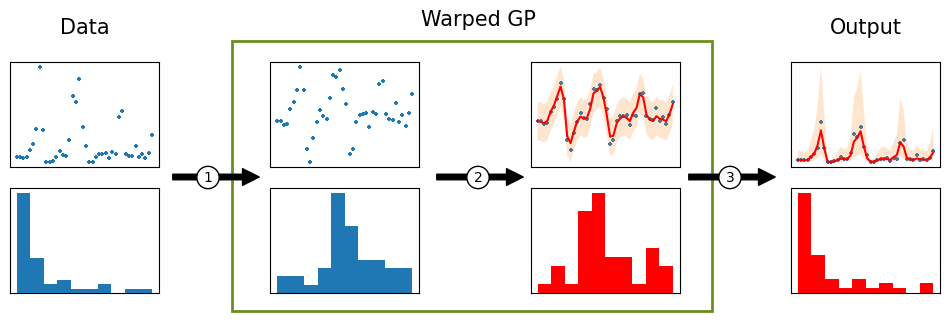

In [27]:
fig, ax = plt.subplots(2, 4, figsize=(12, 3), gridspec_kw={'wspace': 0.75})

v_mid = 0.53
h_mid = 0.515

## Original data
ax[0, 0].scatter(xtrain[:,0], ytrain, s=10, marker='+')
_, _ , _ =  ax[1, 0].hist(ytrain, zorder=15)
ax[0,0].set_title('Data', fontsize=15, pad=20)

## Warped GP
ax_ = fig.add_axes([0.25,0,0.5, 1], zorder=1)
ax_.xaxis.set_visible(False)
ax_.yaxis.set_visible(False)
ax_.patch.set_visible(False)
ax_.axis('off')
rect = Rectangle(
    # (lower-left corner), width, height
    (0.31, 0.05), 0.4, 0.9, fill=False, color="olivedrab", lw=2, 
    transform=fig.transFigure, figure=fig, zorder=1)
#fig.patches.extend([rect])
ax_.add_patch(rect)
ax_.set_zorder(1)

## Arrows
plt.annotate("", xy=(0.22, v_mid), xytext=(0.14, v_mid), xycoords='figure fraction', 
                 arrowprops=dict(facecolor='black', shrink=0.05), zorder=11)
plt.annotate("", xy=(0.44, v_mid), xytext=(0.36, v_mid), xycoords='figure fraction', 
                 arrowprops=dict(facecolor='black', shrink=0.05), zorder=12)
plt.annotate("", xy=(0.65, v_mid), xytext=(0.57, v_mid), xycoords='figure fraction', 
                 arrowprops=dict(facecolor='black', shrink=0.05), zorder=13)

plt.figtext(h_mid, 1, 'Warped GP', fontsize=15, ha='center')

ax[0, 1].scatter(xtrain[:, 0], ytrain_tr, s=10, marker='+')
_, _ , _ =  ax[1, 1].hist(ytrain_tr)

ax[0, 2].scatter(xtrain[:, 0], ytrain_tr, s=10, marker='+')
ax[0, 2].plot(xtrain[:, 0], y_gpr0, 'r')
ax[0, 2].fill_between(xtrain[:, 0], y_gpr0 - 2 * np.sqrt(y_var0), y_gpr0 + 2 * np.sqrt(y_var0), alpha=0.2)
_, _ , _ =  ax[1, 2].hist(y_gpr0, color='r')


## Output
ax[0, 3].set_title('Output', fontsize=15, pad=20)
ax[0, 3].scatter(xtrain[:, 0], ytrain, s=10, marker='+')
ax[0, 3].fill_between(xtrain[:, 0], sp.special.inv_boxcox(y_gpr0 - 2 * np.sqrt(y_var0), lmbda), 
                                    sp.special.inv_boxcox(y_gpr0 + 2 * np.sqrt(y_var0), lmbda), alpha=0.2)
ax[0, 3].plot(xtrain[:, 0], y_gpr, 'r')
_, _ , _ =  ax[1, 3].hist(y_gpr, color='r')

for i in range(2):
    for j in range(4):
        ax[i, j].axes.get_yaxis().set_visible(False)
        ax[i, j].axes.get_xaxis().set_visible(False)

## Numbers
plt.figtext(0.29, v_mid-0.035, "1", ha="center", va="center", zorder=15,
            bbox={"boxstyle" : "circle", "color":"white", "ec":"black", "lw":1})
plt.figtext(h_mid,v_mid-0.035, "2", ha="center", va="center", zorder=15,
            bbox={"boxstyle" : "circle", "color":"white", "ec":"black", "lw":1})
plt.figtext(0.725,v_mid-0.035, "3", ha="center", va="center", zorder=15,
            bbox={"boxstyle" : "circle", "color":"white", "ec":"black", "lw":1})
plt.savefig('warped_gp.pdf', bbox_inches='tight')